# High Dynamic Range Image

## Luka Bašek
## luka.basek@student.um.si

Pri fotografiranju nam dinamični razpon običajno pove kakšna je razlika med svetlimi in temnimi deli fotografirane scene. To ima pomemben vpliv na podrobnosti, ki jih lahko zajamemo.

V scenah kjer imamo mehke sence je dinamični razpon običajno nizek. Brez večjih težav zajamemo vse podrobnosti scene.

V scenah z močnimi ostrimi sencami in močnim virom svetlobe (ali pa različnimi viri svetlobe) pa je lahko dinamični razpon zelo visok. Zaradi omejitev kamere ne moramo zajeti vseh podrobnosti. Ali kamero nastavimo tako, da pravilno zajamemo močno osvetljene dele slike ali pa se osredotočimo na zajem senc. Dinamični razpon kamere pa je primarno določen z bitno ločljivostjo senzorja (posredno nanj vpliva tudi šum). Na dejanski zajem pa vplivajo različne nastavitve: odprtost zaslonke, čas zajema in ojačanje senzorja. Te ne morejo spremeniti dinamičnega razpona, nam pa omogočijo da se osredotočimo na izbran del scene.Kljub temu lahko izkoristimo te nastavitve za umetno povečanje dinamičnega razpona. To storimo tako, da posnamemo več slik, ob katerih spreminjamo eno izmed teh nastavitev (druge pa pustimo). Te slike nato združimo v eno samo sliko z izboljšanimi lastnostmi. Tehniko imenujemo kadriranje (ang. bracketing). Specifično si bomo na vajah pogledali rekonstrukcijo slike z visokim dinamičnim razponom (HDR) s pomočjo kadriranja izpostavljenosti (časa zajema, ang. exposure bracketing). Kot vir nam bo služil naslednji članek:

P. Debevec, J. Malik, Recovering High Dynamic Range Radiance Maps from Photographs, (1997)Kadriranje izpostavitve

## Naloge

V okviru te naloge implementirajte rekonstrukcijo slike z visokim dinamičnim razponom iz serije slik zajete z kadriranjem izpostavljenosti (ang. exposure bracketing). Naloga je deljena na implementacijo algoritma in aplikacije.

Algoritem pokriva rekonstrukcijo funkcije odziva kamere, dodajanje omejitev na rekonstrukcijo te funkcije ter končno rekonstrukcijo slike scene, kot bi bila zajeta s kamero z visokim dinamičnim razponom (z bitno ločljivostjo večjo od 8 bitov).

V aplikaciji algoritem zapakirate v aplikacijo, ki je sposobna naložiti serijo slik z ustreznimi metapodatki o zajemu, jih poslati skozi algoritem za rekonstrukcijo, ter na koncu prikazati sliko z ustrezno preslikavo za prikaz na zaslonu z nizkim dinamičnim razponom.

<h4>Algoritem 60 točk</h4>
<ul>
	<li>osnovna rekonstrukcija funkcije odziva 20 točk</li>
	<li>omejitev srednje vrednosti  10 točk</li>
	<li>omejitev gladkosti 20 točk</li>
    <li>rekonstrukcija slike 10 točk</li>
</ul>

<h4>Aplikacija 60 točk</h4>
<ul>
	<li>nalaganje in obdelava serije slik 20 točk</li>
	<li>avtomatsko branje časa zajemanja 10 točk</li>
	<li>Aplikacija AHE 1 točka</li>
    <li>Prikaz HDR slike 10 točk</li>
    <li>Aplikacija CLAHE 1 točka</li>
</ul>


In [100]:
#Used libraries

import os
import random
import matplotlib.pyplot as plt
import numpy as np
import exifread
import math
from cv2 import cv2

In [88]:
# Constants
DIR = "dataset1/"
IMG_EXTENSION = ".jpg"
EXPOSURE_TIME = "EXIF ExposureTime"
L = 100

In [89]:
def load_images_shape():
    extensions = os.listdir(DIR)
    for extension in extensions:
        if extension.endswith(IMG_EXTENSION):
            img = cv2.imread(DIR + extension)
            return img.shape

In [90]:
def load_images():
    images = []
    exposures = []

    extensions = os.listdir(DIR)
    for extension in extensions:
        if extension.endswith(IMG_EXTENSION):
            img = cv2.imread(DIR + extension,4)
            images.append(img)

            f = open(DIR + extension, 'rb')
            tags = exifread.process_file(f)
            expo_time = eval(str(tags[EXPOSURE_TIME]))
            exposures.append(expo_time)

    return images, exposures

In [91]:
#Loading all dataset images and exposure time from image metadata by channel 
def load_images_exposure(channel=0):
    images = []
    exposures = []

    extensions = os.listdir(DIR)
    for extension in extensions:
        if extension.endswith(IMG_EXTENSION):
            img = cv2.imread(DIR + extension)
            images.append(img[:, :, channel])

            f = open(DIR + extension, 'rb')
            tags = exifread.process_file(f)
            expo_time = eval(str(tags[EXPOSURE_TIME]))
            exposures.append(expo_time)

    return images, exposures

In [92]:
#get pixel samples -> 100 pixels

def get_pixel_samples(test_image):
    pixel_samples = []
    x = []
    y = []
    num_samples = 100
    image_size = test_image.shape[0] * test_image.shape[1]

    while len(pixel_samples) < num_samples:
        i = random.randint(0, image_size - 1)
        pixel_samples.append(i)
        x.append(i / test_image.shape[0])
        y.append(i % test_image.shape[0])

    plt.figure(figsize=(10, 6))
    plt.imshow(test_image, cmap='gray')
    plt.plot(x, y, 'ro')
    plt.axis('off')
    plt.title('Samples')
    plt.show()

    return pixel_samples

In [93]:
def sample_pixel_values(images, samples):
    z = []
    for img in images:
        tmp = list()
        for i in samples:
            tmp.append(img[int(i % img.shape[0]), int(i / img.shape[0])])
        z.append(tmp)
    return z

In [94]:
def compute_response_curve(Z, B, w):
    z_max = 256

    # Number of images
    p = np.size(Z, 0)

    # Number of samples
    n = np.size(Z, 1)

    A = np.zeros(shape=(n * p + z_max + 1, z_max + n), dtype=np.float32)
    b = np.zeros(shape=(np.size(A, 0), 1), dtype=np.float32)

    # Include the data−fitting equations
    k = 0
    for i in range(n):
        for j in range(p):
            z = Z[j][i]
            wij = w[z]
            A[k][z] = wij
            A[k][z_max + i] = -wij
            b[k] = wij * B[j]
            k += 1

    # Fix the curve by setting its middle value to 0
    A[k][128] = 1
    k += 1

    # Include the smoothness equations
    for i in range(z_max - 1):
        A[k][i] = L * w[i + 1]
        A[k][i + 1] = -2 * L * w[i + 1]
        A[k][i + 2] = L * w[i + 1]
        k += 1

    # Solve the system using SVD
    x = np.linalg.lstsq(A, b)[0]
    g = x[0:z_max]
    lE = x[z_max:np.size(x, 0)]

    return g

In [95]:
def create_radiance_map(img_list, g, B, w):
    img_shape = img_list[0].shape
    img_rad_map = np.zeros(img_shape, dtype=np.float64)

    num_images = len(img_list)
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):

            gz = list()
            wz = list()

            for k in range(0, num_images):
                gz.append(g[img_list[k][i, j]][0])
                wz.append(w[img_list[k][i, j]])

            gz = np.asarray(gz)
            wz = np.asarray(wz)

            sum_w = np.sum(wz)
            if sum_w > 0:
                img_rad_map[i, j] = np.sum(wz * (gz - B) / sum_w)
            else:
                img_rad_map[i, j] = gz[num_images // 2] - B[num_images // 2]
    return img_rad_map

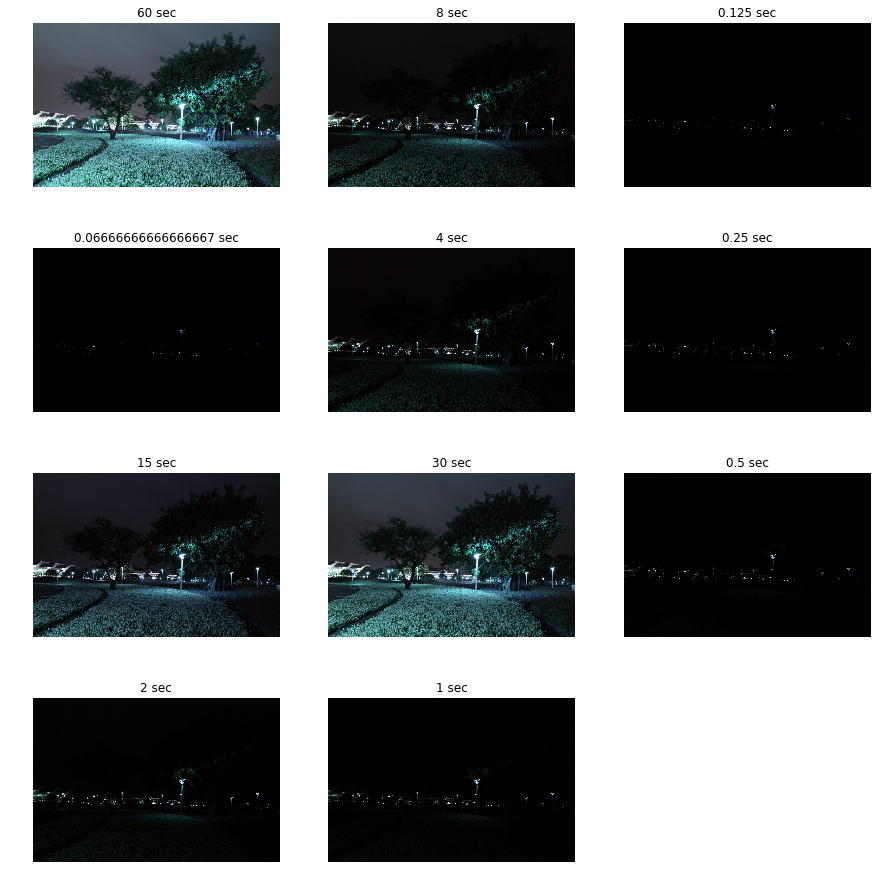

In [96]:
images, expo = load_images()

Cols = 3
rows = len(images) // Cols
rows += len(images) % Cols
Position = range(1, len(images) + 1)

plt.figure(figsize=(15, 20))
fig = plt.figure(1)

for k in range(len(images)):
    ax = fig.add_subplot(rows, Cols, Position[k])
    plt.imshow(images[k]), plt.axis('off'), plt.title(str(expo[k]) + " sec")

plt.show()


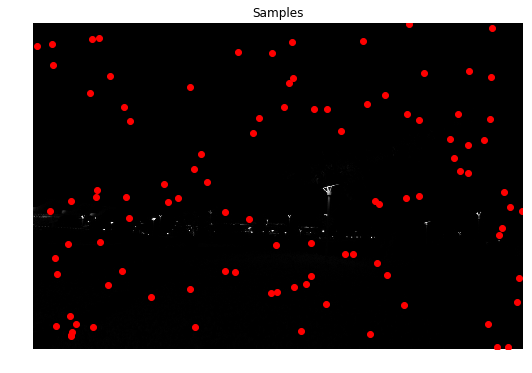

In [97]:
shape = load_images_shape()
width = shape[0]
height = shape[1]

image_list_b, exposure_times = load_images_exposure(channel=0)
image_list_g, _ = load_images_exposure(channel=1)
image_list_r, _ = load_images_exposure(channel=2)

# get random samples on image n = 100
samples = get_pixel_samples(test_image=image_list_r[len(image_list_r) // 2])

# natural log expo times
B = [math.log(e) for e in exposure_times]

# weight function w(z)
w = [z if z <= 0.5 * 255 else 255 - z for z in range(256)]

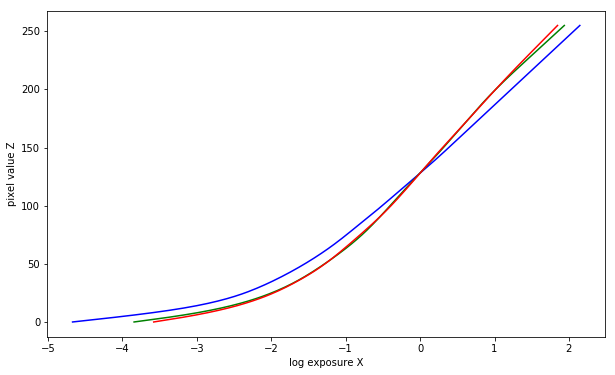

In [98]:
# channel sampled pixel values with dimensions (num_samples,num_images)
z_blue = sample_pixel_values(images=image_list_b, samples=samples)
z_green = sample_pixel_values(images=image_list_g, samples=samples)
z_red = sample_pixel_values(images=image_list_r, samples=samples)

# reconstruction
response_curve_b = compute_response_curve(z_blue, B, w)
response_curve_g = compute_response_curve(z_green, B, w)
response_curve_r = compute_response_curve(z_red, B, w)

plt.figure(figsize=(10, 6))
plt.plot(response_curve_b, range(256), 'b')
plt.plot(response_curve_g, range(256), 'g')
plt.plot(response_curve_r, range(256), 'r')
plt.ylabel('pixel value Z')
plt.xlabel('log exposure X')
plt.show()

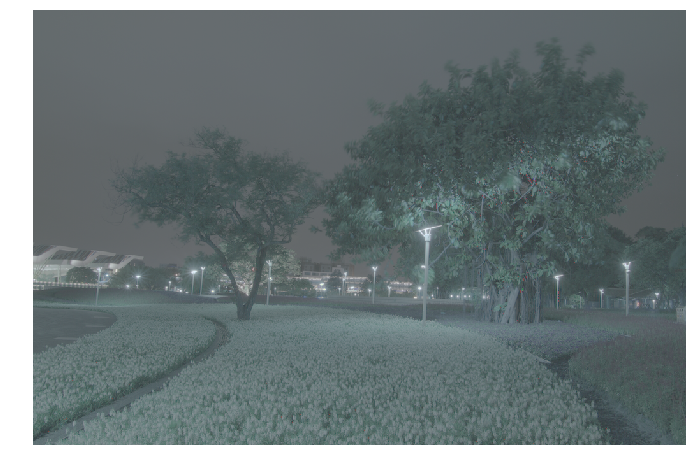

In [99]:
E_b = create_radiance_map(image_list_b, response_curve_b, B, w)
E_g = create_radiance_map(image_list_g, response_curve_g, B, w)
E_r = create_radiance_map(image_list_r, response_curve_r, B, w)

hdr = np.zeros(shape, 'float32')
hdr[..., 0] = np.reshape(np.exp(E_b), (width, height))
hdr[..., 1] = np.reshape(np.exp(E_g), (width, height))
hdr[..., 2] = np.reshape(np.exp(E_r), (width, height))

normalize = lambda zi: (zi - zi.min() / zi.max() - zi.min())

z_disp = normalize(np.log(hdr))

plt.figure(figsize=(12, 8))
plt.imshow(z_disp / z_disp.max())
plt.axis('off')
plt.show()
